In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import label_binarize
from itertools import cycle
import warnings
warnings.filterwarnings('ignore')

In [98]:
# Load the dataset
data = pd.read_csv('corrected.csv')
data.head()

,Marital status,Application mode,Application order,Course,"Daytime/evening attendance""""",Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


In [99]:
# Define categorical and numerical columns
categorical_cols = ['Marital status', 'Application mode', 'Course', 'Daytime/evening attendance', 'Previous qualification', 'Nacionality', "Mother's qualification", "Father's qualification", "Mother's occupation", "Father's occupation", 'Gender', 'International']
numerical_cols = ['Application order', 'Previous qualification (grade)', 'Admission grade', 'Age at enrollment', 'Curricular units 1st sem (credited)', 'Curricular units 1st sem (enrolled)', 'Curricular units 1st sem (evaluations)', 'Curricular units 1st sem (approved)', 'Curricular units 1st sem (grade)', 'Curricular units 1st sem (without evaluations)', 'Curricular units 2nd sem (credited)', 'Curricular units 2nd sem (enrolled)', 'Curricular units 2nd sem (evaluations)', 'Curricular units 2nd sem (approved)', 'Curricular units 2nd sem (grade)', 'Curricular units 2nd sem (without evaluations)', 'Unemployment rate', 'Inflation rate', 'GDP']

# Encode categorical features
categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

In [100]:
# Scale numerical features
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Combine transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_cols),
        ('num', numerical_transformer, numerical_cols)
    ])

In [101]:
# Split the data into train and test sets
# Split the data into train and test sets
X = data.drop('Target', axis=1)
y = data['Target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply dimensionality reduction (PCA)
pca = PCA(n_components=10)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Create a list of machine learning models
models = [
    ('Naive Bayes', GaussianNB()),
    ('Logistic Regression', LogisticRegression(max_iter=1000)),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Random Forest', RandomForestClassifier()),
    ('SVM', SVC(probability=True))
]

In [102]:
# Evaluate and rank the models
results = []
y_test_binarized = label_binarize(y_test, classes=np.unique(y))
for name, model in models:
    model.fit(X_train_pca, y_train)
    y_pred = model.predict(X_test_pca)
    y_pred_prob = model.predict_proba(X_test_pca)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    results.append((name, accuracy, f1, y_pred, y_pred_prob))

# Sort the results based on accuracy and F1-score
results.sort(key=lambda x: (x[1], x[2]), reverse=True)

# Print the results
print("Model Performance:")
for name, accuracy, f1, _, _ in results:
    print(f"{name}: Accuracy={accuracy:.4f}, F1-score={f1:.4f}")

Model Performance:
Logistic Regression: Accuracy=0.6542, F1-score=0.5956
Random Forest: Accuracy=0.6508, F1-score=0.6105
Naive Bayes: Accuracy=0.5887, F1-score=0.5391
Decision Tree: Accuracy=0.5650, F1-score=0.5658
SVM: Accuracy=0.4723, F1-score=0.3030


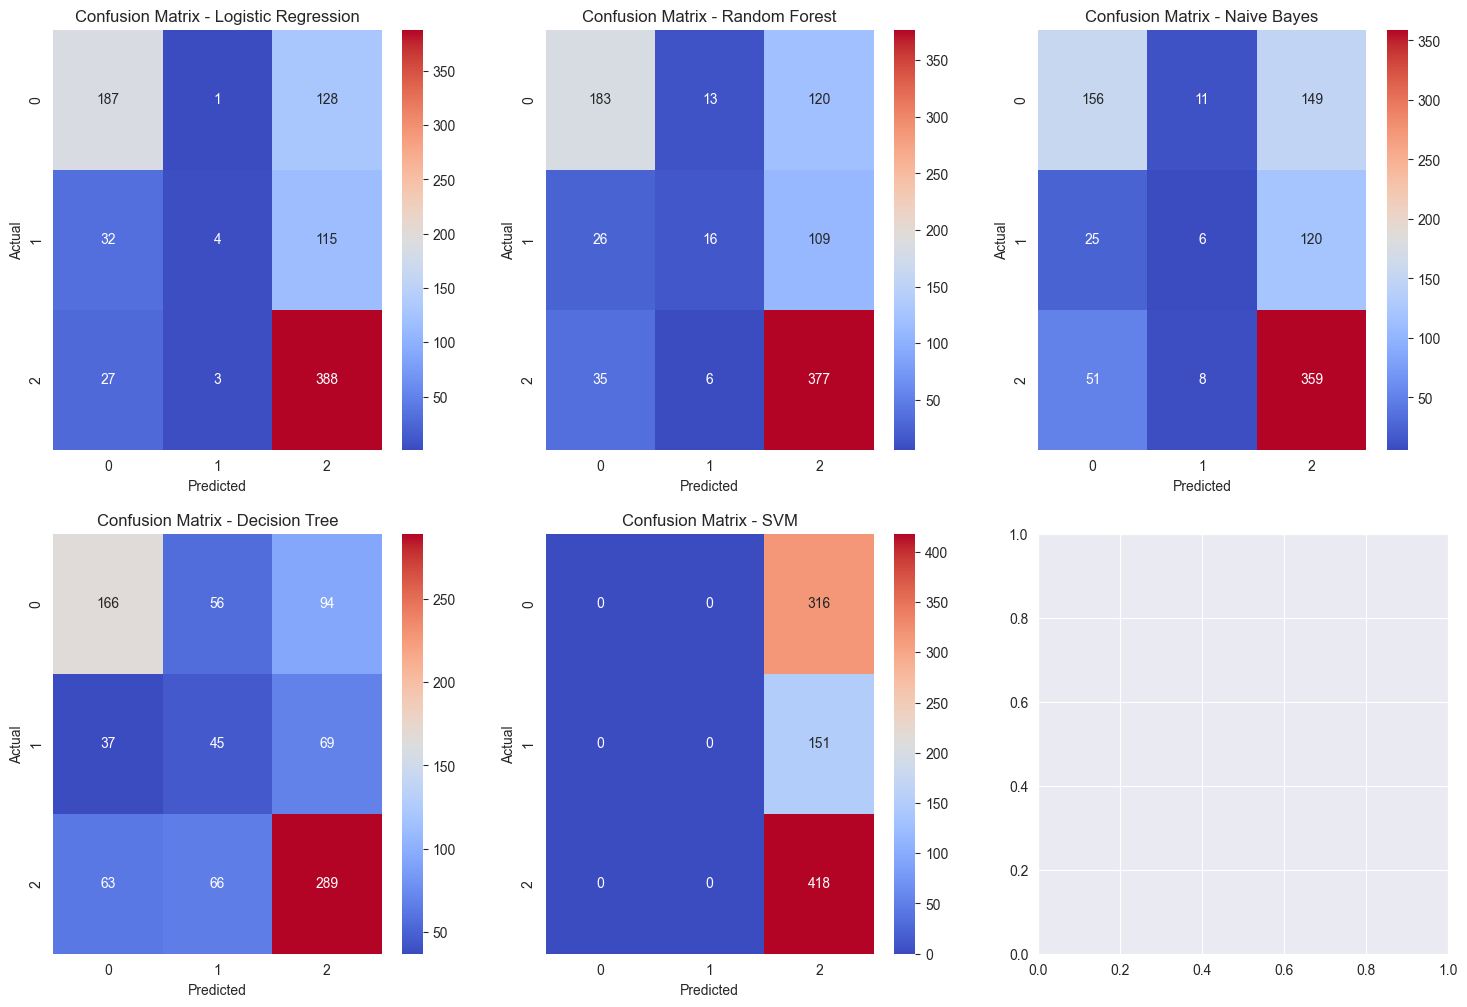

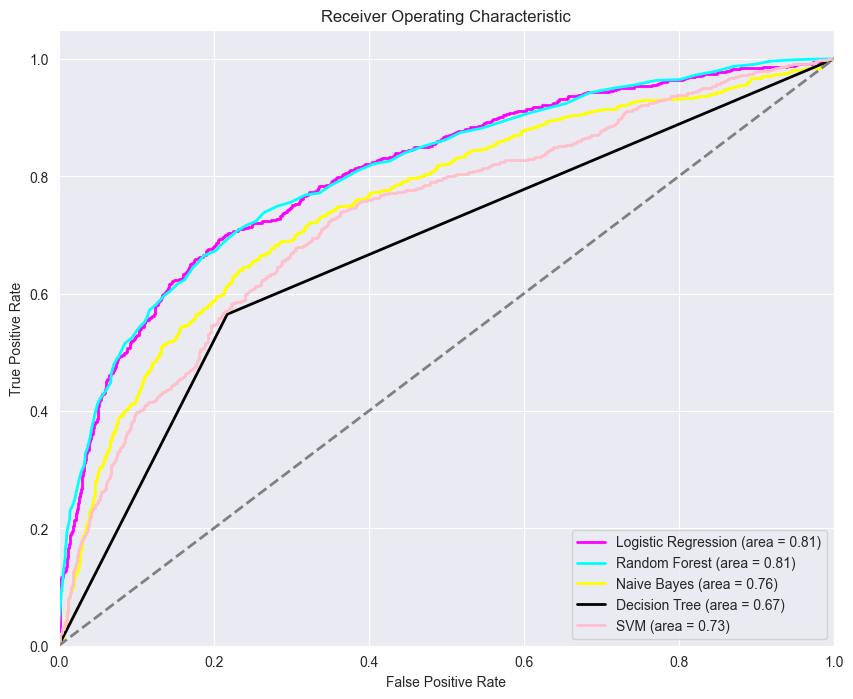

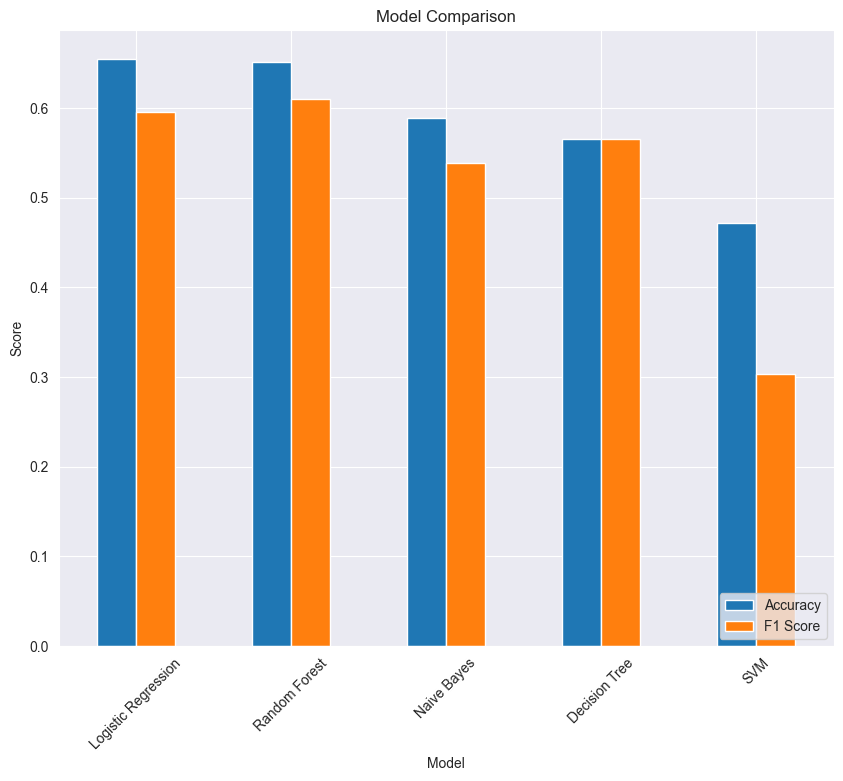

In [103]:
# Confusion matrices
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, (name, _, _, y_pred, _) in enumerate(results):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', ax=axes[i], cmap='coolwarm')
    axes[i].set_title(f'Confusion Matrix - {name}')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

# ROC curves
fig, ax = plt.subplots(figsize=(10, 8))

colors = cycle(['magenta', 'cyan', 'yellow', 'black', 'pink'])
for (name, _, _, _, y_pred_prob), color in zip(results, colors):
    fpr, tpr, _ = roc_curve(y_test_binarized.ravel(), y_pred_prob.ravel())
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, color=color, lw=2, label=f'{name} (area = {roc_auc:.2f})')

ax.plot([0, 1], [0, 1], linestyle='--', color='gray', lw=2)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic')
ax.legend(loc="lower right")

# Bar plot for Accuracy and F1 Score
metrics_df = pd.DataFrame(results, columns=['Model', 'Accuracy', 'F1 Score', 'y_pred', 'y_pred_prob']).drop(columns=['y_pred', 'y_pred_prob'])

fig, ax = plt.subplots(figsize=(10, 8))
metrics_df.set_index('Model').plot(kind='bar', ax=ax, color=['#1f77b4', '#ff7f0e'])
ax.set_title('Model Comparison')
ax.set_xlabel('Model')
ax.set_ylabel('Score')
plt.xticks(rotation=45)
plt.legend(loc="lower right")
plt.show()